In [1]:
import cv2
import torch

print(f"OpenCV version: {cv2.__version__}")
print(f"Torch version: {torch.__version__}")
print(f"Cuda available: {torch.cuda.is_available()}")

OpenCV version: 4.1.1
Torch version: 1.7.0
Cuda available: True


In [2]:
# Free up memory
import torch
import gc

def free_mem():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    
free_mem()

## Load trained model

In [3]:
import json

#metadata = "mstd_metadata.json"
metadata = "mstd_metadata_no_other_sign.json"

with open(metadata, "r") as f:
    mstd_metadata = json.load(f)

In [4]:
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()
#cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_1x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))
#cfg.MODEL.WEIGHTS = "/data/retinanet_output_3x/model_final.pth"
#cfg.MODEL.WEIGHTS = "/data/retinanet_output_3x_scaled480p/model_final.pth"
#cfg.MODEL.WEIGHTS = "/data/retinanet_output_1x_scaled720p/model_final.pth"
cfg.MODEL.WEIGHTS = "/data/retinanet_output_3x_scaled360p_no_other_sign/model_final.pth"
cfg.MODEL.META_ARCHITECTURE = "RetinaNet"
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.35
cfg.MODEL.RETINANET.NUM_CLASSES = len(mstd_metadata["thing_classes"])
cfg.MODEL.DEVICE = "cuda"
cfg.TEST.DETECTIONS_PER_IMAGE = 10
cfg.INPUT.MAX_SIZE_TEST = 640
cfg.INPUT.MIN_SIZE_TEST = 360
cfg.INPUT.RANDOM_FLIP = "none"

Loading config /usr/local/lib/python3.6/dist-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [5]:
from detectron2.engine import DefaultPredictor
predictor = DefaultPredictor(cfg)

free_mem()

In [6]:
mem_params = sum([param.nelement()*param.element_size() for param in predictor.model.parameters()])
mem_bufs = sum([buf.nelement()*buf.element_size() for buf in predictor.model.buffers()])
mem = mem_params + mem_bufs # in bytes
print(f"Mem: {mem / (1024 * 1024)}MB")

Mem: 170.36589813232422MB


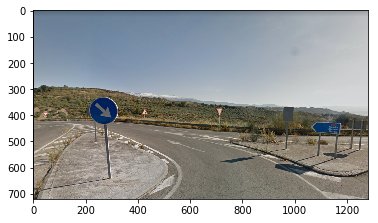

In [6]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

img = cv2.imread("test_maps720p.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [7]:
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt
import time
import cv2
%matplotlib inline

img = cv2.imread("test_maps720p.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(f"Img shape: {img.shape}")

start_time = time.time()
output = predictor(img)
print(f"--- Avg Inference time: {time.time() - start_time}s ---")

Img shape: (720, 1280, 3)
--- Avg Inference time: 63.97825336456299s ---


Primero probamos con la configuración por defecto de la jetson.

Podemos ver el estado `sudo /usr/bin/jetson_clocks --show`

```bash
SOC family:tegra210  Machine:NVIDIA Jetson Nano 2GB Developer Kit
Online CPUs: 0-3
cpu0: Online=1 Governor=schedutil MinFreq=1200000 MaxFreq=1479000 CurrentFreq=1224000 IdleStates: WFI=1 c7=1
cpu1: Online=1 Governor=schedutil MinFreq=1200000 MaxFreq=1479000 CurrentFreq=1224000 IdleStates: WFI=1 c7=1
cpu2: Online=1 Governor=schedutil MinFreq=1200000 MaxFreq=1479000 CurrentFreq=1479000 IdleStates: WFI=1 c7=1
cpu3: Online=1 Governor=schedutil MinFreq=1200000 MaxFreq=1479000 CurrentFreq=1224000 IdleStates: WFI=1 c7=1
GPU MinFreq=76800000 MaxFreq=921600000 CurrentFreq=76800000
EMC MinFreq=204000000 MaxFreq=1600000000 CurrentFreq=1600000000 FreqOverride=0
Fan: PWM=0
NV Power Mode: MAXN
```

Vemos que la frecuencia mínima de la GPU es baja, con el siguinte comando `sudo /usr/bin/jetson_clocks --fan` podemos ponerla al máximo de forma quer no se pierda tiempo hasta que la GPU se ponga a pleno funcionamiento.
```bash
SOC family:tegra210  Machine:NVIDIA Jetson Nano 2GB Developer Kit
Online CPUs: 0-3
cpu0: Online=1 Governor=schedutil MinFreq=1479000 MaxFreq=1479000 CurrentFreq=1479000 IdleStates: WFI=0 c7=0
cpu1: Online=1 Governor=schedutil MinFreq=1479000 MaxFreq=1479000 CurrentFreq=1479000 IdleStates: WFI=0 c7=0
cpu2: Online=1 Governor=schedutil MinFreq=1479000 MaxFreq=1479000 CurrentFreq=1479000 IdleStates: WFI=0 c7=0
cpu3: Online=1 Governor=schedutil MinFreq=1479000 MaxFreq=1479000 CurrentFreq=1479000 IdleStates: WFI=0 c7=0
GPU MinFreq=921600000 MaxFreq=921600000 CurrentFreq=921600000
EMC MinFreq=204000000 MaxFreq=1600000000 CurrentFreq=1600000000 FreqOverride=1
Fan: PWM=255
NV Power Mode: MAXN
```

In [ ]:
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt
import time
import cv2
%matplotlib inline

img = cv2.imread("test_maps720p.png")
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (cfg.INPUT.MAX_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST))
print(f"Img shape: {img.shape}")

# Warmup
with torch.cuda.amp.autocast():
    output = predictor(img)
print("Warmup completed")

iters = 50
start_time = time.time()
for i in range(iters):
    with torch.cuda.amp.autocast():
        _ = predictor(img)
print(f"--- Avg Inference time: {(time.time() - start_time) / iters}s ---")

v = Visualizer(img[:, :, ::-1], metadata=mstd_metadata)
v = v.draw_instance_predictions(output["instances"].to("cpu"))
plt.imsave("test_maps_output.png", v.get_image()[:, :, ::-1])
plt.imshow(v.get_image()[:, :, ::-1])

Img shape: (360, 640, 3)
Warmup completed


In [7]:
import torch
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  177908 KB |  497866 KB |   67238 MB |   67064 MB |
|       from large pool |  158208 KB |  463727 KB |   63850 MB |   63695 MB |
|       from small pool |   19700 KB |   35282 KB |    3388 MB |    3368 MB |
|---------------------------------------------------------------------------|
| Active memory         |  177908 KB |  497866 KB |   67238 MB |   67064 MB |
|       from large pool |  158208 KB |  463727 KB |   63850 MB |

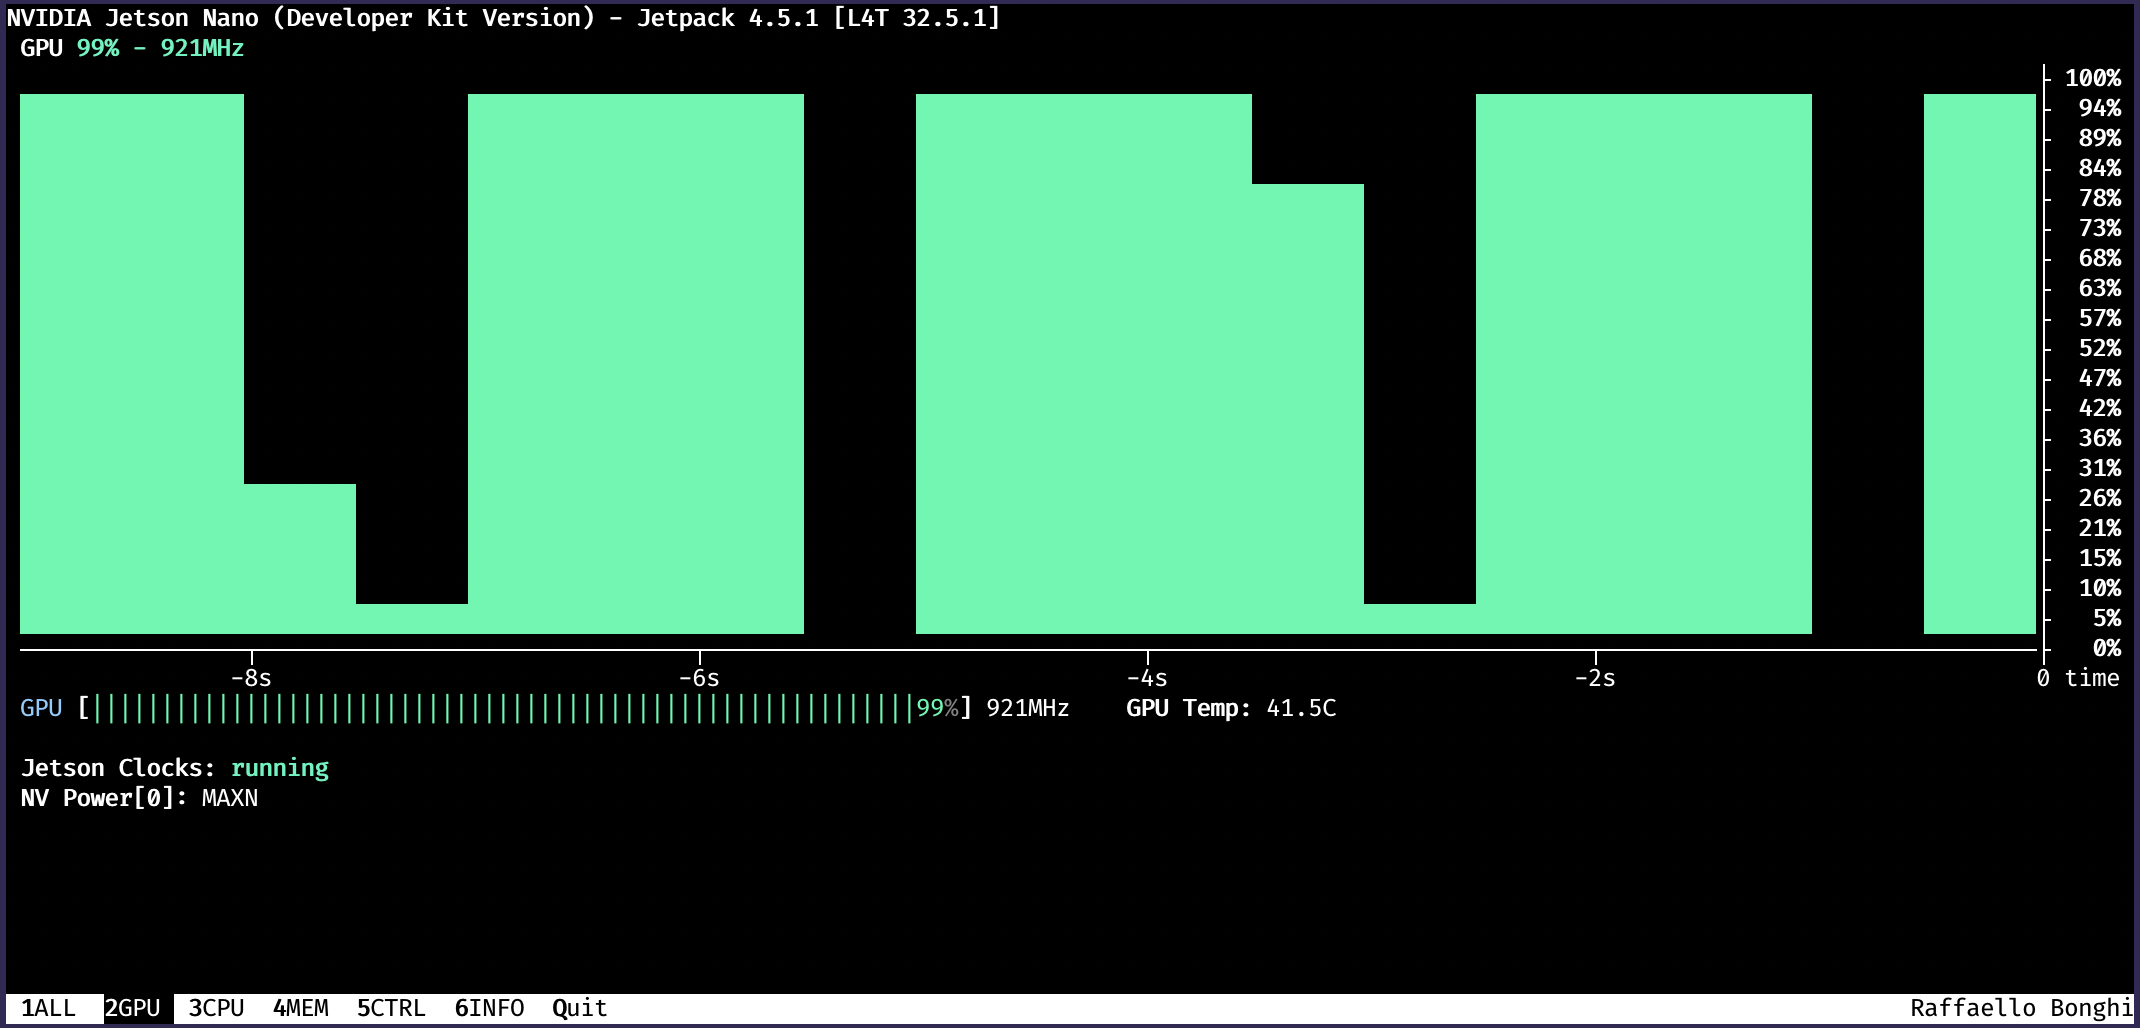

# Live camera

In [7]:
import cv2

WIDTH = cfg.INPUT.MAX_SIZE_TEST
HEIGHT = cfg.INPUT.MIN_SIZE_TEST
#WIDTH = 640
#HEIGHT = 360

gstreamer_addr = f"v4l2src device=/dev/video0 ! video/x-raw, width=(int){WIDTH}, height=(int){HEIGHT}, framerate=(fraction)30/1 ! videoconvert !  video/x-raw, format=(string)BGR ! appsink"
cap = cv2.VideoCapture(gstreamer_addr, cv2.CAP_GSTREAMER)

print(f"Buffer set: {cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)}") 

Buffer set: False


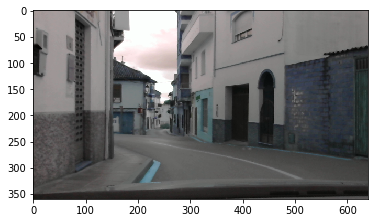

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

ret, frame = cap.read()
assert ret, "Failed to read frame"
plt.imshow(frame)

In [9]:
import ipywidgets
from IPython.display import display
from detectron2.utils.video_visualizer import VideoVisualizer
from jetcam.utils import bgr8_to_jpeg
import time

image_widget = ipywidgets.Image(format='jpeg')
display(image_widget)

vis = VideoVisualizer(metadata=mstd_metadata)

# GPU warmup
print("Warming up...", end=" ")
ret, frame = cap.read()
assert ret, "Failed to read frame"
with torch.cuda.amp.autocast():
    pred = predictor(frame)
print("Done")

while True:
    loop_start = time.time()
    
    if cap.grab():
        ret, frame = cap.retrieve()
    else:
        print("Error reading frame. Skipping")
        continue
        
    start_time = time.time()
    with torch.cuda.amp.autocast():
        pred = predictor(frame)
    inference_time = time.time() - start_time
    
    v = vis.draw_instance_predictions(frame, pred["instances"].to("cpu"))
    image_widget.value = bgr8_to_jpeg(v.get_image())
    
    loop_time = time.time() - loop_start
    
    print(f"--- Time Stats \t Loop: {loop_time}s \t Inference: {inference_time} ---",
          end='\r', flush=True)

#camera.running = True
#camera.observe(update_frame, names='value')

Image(value=b'', format='jpeg')

Warming up... Done


KeyboardInterrupt: 

In [10]:
cap.release()

## Export to TensorRT

In [31]:
from detectron2.modeling import RetinaNet, build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.export import Caffe2Tracer
import onnx

torch_model = build_model(cfg)
DetectionCheckpointer(torch_model).resume_or_load(cfg.MODEL.WEIGHTS)
torch_model.eval()

original_image = detection_utils.read_image(traffic_sign_detector/test_maps.png,
                                       format=cfg.INPUT.FORMAT)
aug = T.ResizeShortestEdge(
            [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST],
            cfg.INPUT.MAX_SIZE_TEST)
height, width = original_image.shape[:2]
image = aug.get_transform(original_image).apply_image(original_image)
image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
inputs = {"image": image, "height": height, "width": width}

exported_model = Caffe2Tracer(cfg, torch_model, [inputs])

ModuleNotFoundError: No module named 'detectron2.export'

In [1]:
!cd ../detectron2/tools/deploy && \
python3 ./export_model.py --config-file /data/detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml \
                          --format onnx  --output /data/model_onnx \
                          --sample-image /data/traffic_sign_detector/test_maps.png \
                          MODEL.WEIGHTS /data/output/model_final.pth \
                          MODEL.DEVICE cpu

Failed to load OpenCL runtime
[04/26 08:28:06 detectron2]: Command line arguments: Namespace(config_file='/data/detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml', export_method='caffe2_tracing', format='onnx', opts=['MODEL.WEIGHTS', '/data/output/model_final.pth', 'MODEL.DEVICE', 'cpu'], output='/data/model_onnx', run_eval=False, sample_image='/data/traffic_sign_detector/test_maps.png')
/usr/local/lib/python3.6/dist-packages/torch/onnx/utils.py:258: UserWarning: `add_node_names' can be set to True only when 'operator_export_type' is `ONNX`. Since 'operator_export_type' is not set to 'ONNX', `add_node_names` argument will be ignored.
  "`{}` argument will be ignored.".format(arg_name, arg_name))
/usr/local/lib/python3.6/dist-packages/torch/onnx/utils.py:258: UserWarning: `do_constant_folding' can be set to True only when 'operator_export_type' is `ONNX`. Since 'operator_export_type' is not set to 'ONNX', `do_constant_folding` argument will be ignored.
  "`{}` argu

In [5]:
!/usr/src/tensorrt/bin/trtexec --onnx=/data/model_onnx/model.onnx --saveEngine=resnet50_engine.trt

&&&& RUNNING TensorRT.trtexec # /usr/src/tensorrt/bin/trtexec --onnx=/data/model_onnx/model.onnx --saveEngine=resnet50_engine.trt
[04/26/2021-08:57:34] [I] === Model Options ===
[04/26/2021-08:57:34] [I] Format: ONNX
[04/26/2021-08:57:34] [I] Model: /data/model_onnx/model.onnx
[04/26/2021-08:57:34] [I] Output:
[04/26/2021-08:57:34] [I] === Build Options ===
[04/26/2021-08:57:34] [I] Max batch: 1
[04/26/2021-08:57:34] [I] Workspace: 16 MB
[04/26/2021-08:57:34] [I] minTiming: 1
[04/26/2021-08:57:34] [I] avgTiming: 8
[04/26/2021-08:57:34] [I] Precision: FP32
[04/26/2021-08:57:34] [I] Calibration: 
[04/26/2021-08:57:34] [I] Safe mode: Disabled
[04/26/2021-08:57:34] [I] Save engine: resnet50_engine.trt
[04/26/2021-08:57:34] [I] Load engine: 
[04/26/2021-08:57:34] [I] Builder Cache: Enabled
[04/26/2021-08:57:34] [I] NVTX verbosity: 0
[04/26/2021-08:57:34] [I] Inputs format: fp32:CHW
[04/26/2021-08:57:34] [I] Outputs format: fp32:CHW
[04/26/2021-08:57:34] [I] Input build shapes: model
[04/26/

In [1]:
import cv2
import onnx
import onnx_tensorrt.backend as backend

img = cv2.imread("traffic_sign_detector/test_maps.png")

model = onnx.load("/data/model_onnx/model.onnx")
engine = backend.prepare(model, device='CUDA:0')

output_data = engine.run(img)[0]
print(output_data)
print(output_data.shape)

RuntimeError: While parsing node number -1:
builtin_op_importers.cpp:3661 In function importFallbackPluginImporter:
[8] Assertion failed: creator && "Plugin not found, are the plugin name, version, and namespace correct?"

In [1]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
import numpy as np

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = "/data/retinanet_output_3x_scaled480p/model_final.pth"
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.35
cfg.MODEL.RETINANET.NUM_CLASSES = 401
cfg.INPUT.MAX_SIZE_TEST = 224
cfg.INPUT.MIN_SIZE_TEST = 224
cfg.INPUT.RANDOM_FLIP = "none"
cfg.MODEL.DEVICE = "cuda"

Loading config /usr/local/lib/python3.6/dist-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [2]:
from detectron2.modeling import build_model

torch_model = build_model(cfg)

In [3]:
from detectron2.utils.events import EventStorage
from detectron2.structures import Instances, Boxes
from torch2trt import torch2trt
import torch

H = cfg.INPUT.MIN_SIZE_TEST
W = cfg.INPUT.MAX_SIZE_TEST

instances = Instances((H, W))
instances.set("gt_boxes", Boxes(torch.ones((3,4))))
instances.set("gt_classes", torch.tensor([1,2,3]))

data = {
    "image": torch.ones((3, H, W)),
    "height": H,
    "width": W,
    "instances": instances
}

class CloneRet():
        def __init__(self, data):
            self.data = data
            
        def __getitem__(self, idx):
            return [self.data]

class DataWithClone():
    def __init__(self, data):
        self.data = data
    
    def clone(self):
        return CloneRet(self.data)

with EventStorage() as storage:
    trt_model = torch2trt(torch_model, [DataWithClone(data)])

AttributeError: 'list' object has no attribute 'shape'

## Custom model optimization

In [1]:
predictor_half = predictor
predictor_half.model = predictor_half.model.half()

NameError: name 'predictor' is not defined

In [ ]:
type(predictor_half.model)

In [1]:
from detectron2.modeling import META_ARCH_REGISTRY
from detectron2.modeling.meta_arch import RetinaNet
from typing import Dict, List, Tuple
from torch import Tensor, nn

@META_ARCH_REGISTRY.register()
class RetinaNetHalf(RetinaNet):
    def __init__(self, cfg):
        super().__init__(cfg)
        
    def forward(self, batched_inputs: Tuple[Dict[str, Tensor]]):
        images = self.preprocess_image(batched_inputs)
        features = self.backbone(images.tensor.half())   # <-- This is the important line
        tures = [features[f] for f in self.head_in_features]

        anchors = self.anchor_generator(features)
        pred_logits, pred_anchor_deltas = self.head(features)
        # Transpose the Hi*Wi*A dimension to the middle:
        pred_logits = [permute_to_N_HWA_K(x, self.num_classes) for x in pred_logits]
        pred_anchor_deltas = [permute_to_N_HWA_K(x, 4) for x in pred_anchor_deltas]

        if self.training:
            assert not torch.jit.is_scripting(), "Not supported"
            assert "instances" in batched_inputs[0], "Instance annotations are missing in training!"
            gt_instances = [x["instances"].to(self.device) for x in batched_inputs]

            gt_labels, gt_boxes = self.label_anchors(anchors, gt_instances)
            losses = self.losses(anchors, pred_logits, gt_labels, pred_anchor_deltas, gt_boxes)

            if self.vis_period > 0:
                storage = get_event_storage()
                if storage.iter % self.vis_period == 0:
                    results = self.inference(
                        anchors, pred_logits, pred_anchor_deltas, images.image_sizes
                    )
                    self.visualize_training(batched_inputs, results)

            return losses
        else:
            results = self.inference(anchors, pred_logits, pred_anchor_deltas, images.image_sizes)
            if torch.jit.is_scripting():
                return results
            processed_results = []
            for results_per_image, input_per_image, image_size in zip(
                results, batched_inputs, images.image_sizes
            ):
                height = input_per_image.get("height", image_size[0])
                width = input_per_image.get("width", image_size[1])
                r = detector_postprocess(results_per_image, height, width)
                processed_results.append({"instances": r})
            return processed_results

In [1]:
import json

with open("mstd_metadata.json", "r") as f:
    mstd_metadata = json.load(f)

In [4]:
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))
#cfg.MODEL.WEIGHTS = "/data/retinanet_output_3x/model_final.pth"
cfg.MODEL.WEIGHTS = "/data/retinanet_output_3x_scaled480p/model_final.pth"
#cfg.MODEL.WEIGHTS = "/data/retinanet_output_1x_scaled720p/model_final.pth"
cfg.MODEL.META_ARCHITECTURE = "RetinaNet"
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.35
cfg.MODEL.RETINANET.NUM_CLASSES = len(mstd_metadata["thing_classes"])
cfg.MODEL.DEVICE = "cuda"
cfg.SOLVER.AMP.ENABLED = True
cfg.TEST.DETECTIONS_PER_IMAGE = 10
cfg.INPUT.MAX_SIZE_TEST = 640
cfg.INPUT.MIN_SIZE_TEST = 480
cfg.INPUT.RANDOM_FLIP = "none"

Loading config /usr/local/lib/python3.6/dist-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [5]:
from detectron2.engine import DefaultPredictor
predictor = DefaultPredictor(cfg)

SystemError: Bad call flags in PyCFunction_Call. METH_OLDARGS is no longer supported!

In [8]:
import cv2

img = cv2.imread("test_maps720p.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#img = cv2.resize(img, (cfg.INPUT.MAX_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST))
print(f"Img shape: {img.shape}")

output = predictor(img)

Img shape: (720, 1280, 3)


RuntimeError: Input type (torch.cuda.HalfTensor) and weight type (torch.cuda.FloatTensor) should be the same